In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [110]:
from pathlib import Path

from torch.utils.data import Dataset, DataLoader
from PIL import Image

from torchvision.transforms import  ToTensor, Normalize, Compose, Resize, Grayscale

custom_transform = Compose([
    Resize((128, 128)),
    Grayscale(),
    ToTensor(),
    # Normalize((0.5,), (0.5,))
])

age_list = [img.stem.split("_")[0] for img in Path("data/train").glob("*/*.jpg")]
age_min = 1 # torch.Tensor(list(map(int, age_list))).min()
age_max = 117 # torch.Tensor(list(map(int, age_list))).max()
print(age_min, age_max)
target_transform = lambda x: (x - age_min)/(age_max - age_min)

class create_dataset(Dataset):
    def __init__(self, root: str, transform = custom_transform, target_transform = target_transform):
        self.data = list(Path(root).glob("*/*.jpg"))
        
        # normalizing the input data
        self.age = [img.stem.split("_")[0] for img in self.data]
        self.age = torch.Tensor(list(map(int, self.age)))
        
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]
        image = Image.open(image_path)
        image = self.transform(image)
        age = self.target_transform(self.age[index])
        return image, age
    
train_dir = "data/train"
test_dir = "data/test"

train_data = create_dataset(train_dir, custom_transform, target_transform)
test_data = create_dataset(test_dir, custom_transform, target_transform)

len(train_data), len(test_data)

tensor(1.) tensor(116.)


(18966, 4742)

In [111]:
test_data[2][1]

tensor(0.8609)

In [112]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataloader), len(test_dataloader)

(297, 75)

In [113]:
import torch
from torch import nn

class model_customV0(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.age_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128*16*16, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=256, out_features=output_shape)
        )
        
    def forward(self, x):
        # x = self.conv_block_1(x)
        # # print(x[:5])
        # x = self.conv_block_2(x)
        # # print(x[:5])
        # x = self.conv_block_3(x)
        # # print(x[:5])
        # age = self.age_fc(x)
        age = self.age_fc(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))
        return age
    

model_age = model_customV0(input_shape=1, output_shape=1).to(device)

In [239]:
age_loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.SGD(params = model_age.parameters(),
                           lr = 0.003,
                        #    weight_decay=0.0001
                           )



In [240]:
x, y = next(iter(train_dataloader))

y_hat = model_age(x.to(device))
age_loss_fn(y_hat, y.type(torch.float).to(device))

tensor(0.0420, device='cuda:0', grad_fn=<MseLossBackward0>)

In [241]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device= device):
    model.train()

    train_loss = 0.0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.unsqueeze(1).to(device)
        
        y_preds = model(X)
#         print(y.dtype, y_preds.dtype, y_pred_logits.dtype)
#         print(y_pred_logits)
#         print(y.shape, y_preds.shape, y_pred_logits.shape)

        loss = loss_fn(y_preds, y.type(torch.float))
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()


    train_loss /= len(dataloader)
    return train_loss.detach().cpu().numpy() # tensor.detach() to remove the grad associated

In [242]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
    model.eval()

    test_loss = 0.0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.unsqueeze(1).to(device)

            test_preds = model(X)
            
            loss = loss_fn(test_preds, y.type(torch.float))
            test_loss += loss


        test_loss /= len(dataloader)
    return test_loss.cpu().numpy()

In [243]:
from tqdm.auto import tqdm

def train(model:torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs = 5,
          device = device):

    results = {"train loss": [],
               "test loss": []}


    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device)

        test_loss = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(f"train loss {train_loss:.4f} | test loss {test_loss:.4f} | ")
        print("*"*14)

        # train_losses =

        if results['test loss']:
            if test_loss < min(results['test loss']):
                torch.save(model.state_dict(), "models/model_age.pt")

        results['train loss'].append(train_loss)
        results['test loss'].append(test_loss)        

    return results

In [244]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 100

from timeit import default_timer as timer

start_time = timer()

model_results = train(model=model_age.to(device),
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=age_loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time}")

  0%|          | 0/100 [00:00<?, ?it/s]

train loss 0.0111 | test loss 0.0116 | 
**************
train loss 0.0111 | test loss 0.0116 | 
**************
train loss 0.0110 | test loss 0.0116 | 
**************
train loss 0.0110 | test loss 0.0116 | 
**************
train loss 0.0110 | test loss 0.0115 | 
**************
train loss 0.0109 | test loss 0.0118 | 
**************
train loss 0.0108 | test loss 0.0118 | 
**************
train loss 0.0107 | test loss 0.0114 | 
**************
train loss 0.0108 | test loss 0.0113 | 
**************
train loss 0.0107 | test loss 0.0112 | 
**************
train loss 0.0106 | test loss 0.0112 | 
**************
train loss 0.0107 | test loss 0.0112 | 
**************
train loss 0.0106 | test loss 0.0113 | 
**************
train loss 0.0106 | test loss 0.0112 | 
**************
train loss 0.0105 | test loss 0.0111 | 
**************
train loss 0.0105 | test loss 0.0111 | 
**************
train loss 0.0104 | test loss 0.0111 | 
**************
train loss 0.0104 | test loss 0.0111 | 
**************
train loss

In [86]:
path = Path("models")
path.mkdir(parents=True, exist_ok=True)

model_save_path = path / "model_age.pt"
torch.save(model_age.state_dict(), model_save_path)

(-0.5, 127.5, 127.5, -0.5)

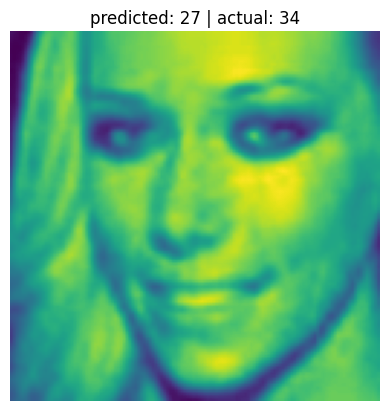

In [289]:
import matplotlib.pyplot as plt

model_age = model_customV0(input_shape=1, output_shape=1).to(device=device)
model_age.load_state_dict(torch.load(Path("models") / "model_age.pt"))

rand_idx = torch.randint(0, len(test_data), size=(1,)).item()

X, y = test_data[rand_idx]
X, y = X.unsqueeze(0).to(device), y.unsqueeze(0).to(device)

model_age.eval()
with torch.inference_mode():
    y_preds = model_age(X)

plt.imshow(X.squeeze(0).permute(1, 2, 0).cpu())
plt.title(f"predicted: {int((y_preds.item() * (age_max - age_min)) + age_min)} | actual: {int((y * (age_max - age_min)) + age_min)}")
plt.axis(False)

In [201]:
model_results

{'train loss': [array(0.01112642, dtype=float32)],
 'test loss': [array(0.01166613, dtype=float32)]}